# Saliency Maps: Which Pixels Matter?

Given a trained CNN and an input image, a saliency map shows which pixels the model relies on for its prediction. The method is simple: backpropagate the predicted class score to the input and look at the gradient magnitudes.

Same backpropagation as training, but instead of asking "how should the **weights** change?", we ask "how sensitive is the output to each **input pixel**?"

In [ ]:
import os, random
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## 1 -- Train a CNN

We reuse the same `SimpleCNN` and CIFAR-10 setup from notebook 03. We need a trained model before we can compute saliency maps.

In [2]:
# Data setup (same as notebook 03)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

data_root = "../data"
train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_ds, val_ds = random_split(train_full, [len(train_full) - val_size, val_size],
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

CLASSES = train_full.classes
print(f"Classes: {CLASSES}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# Same CNN architecture from notebook 03
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train for 5 epochs
for epoch in range(1, 6):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)

    # Quick val check
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_correct += (model(xb).argmax(1) == yb).sum().item()
            val_total += xb.size(0)

    print(f"Epoch {epoch} | train acc {correct/total:.3f} | val acc {val_correct/val_total:.3f}")

Epoch 1 | train acc 0.507 | val acc 0.611


Epoch 2 | train acc 0.642 | val acc 0.656


Epoch 3 | train acc 0.692 | val acc 0.675


Epoch 4 | train acc 0.725 | val acc 0.690


Epoch 5 | train acc 0.747 | val acc 0.701


## 2 -- Pick a Test Image

We grab a single image from the test set and display it. We also need a helper to undo the normalisation for visualisation — the model sees normalised tensors, but we want to display the original RGB image.

True label: airplane
Image shape: torch.Size([3, 32, 32])


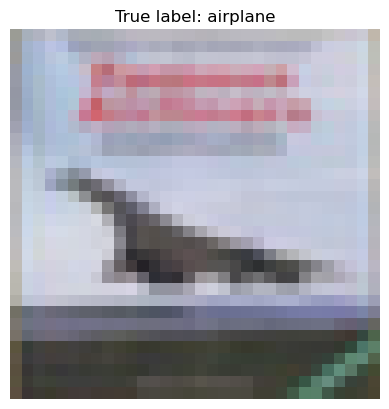

In [4]:
def unnormalize(img_tensor):
    """Undo CIFAR-10 normalization so we can display the image."""
    mean = torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
    std = torch.tensor(CIFAR10_STD).view(3, 1, 1)
    return (img_tensor.cpu() * std + mean).clamp(0, 1)

# Grab one image
image, label = test_ds[3]  # pick an example
print(f"True label: {CLASSES[label]}")
print(f"Image shape: {image.shape}")  # (3, 32, 32)

# Display it
plt.imshow(unnormalize(image).permute(1, 2, 0))  # (H, W, 3) for matplotlib
plt.title(f"True label: {CLASSES[label]}")
plt.axis("off")
plt.show()

## 3 -- Compute the Saliency Map

Four steps:

1. **Prepare the input** -- add a batch dimension and set `requires_grad=True` on the image tensor (normally only weights have this).
2. **Forward pass** -- get the 10 class logits.
3. **Backward pass** -- call `.backward()` on the predicted class score (not the loss). This fills `image.grad`.
4. **Build the map** -- take `abs()` of the gradient and `max` across the 3 color channels to get a single (32, 32) heatmap.

In [5]:
def compute_saliency(model, image, device):
    """Compute a saliency map for a single image.
    
    Returns:
        saliency: (H, W) tensor -- gradient magnitude per pixel
        pred_class: int -- the class the model predicted
    """
    model.eval()

    # Step 1: prepare input -- enable gradients on the image
    inp = image.unsqueeze(0).to(device)    # (1, 3, 32, 32)
    inp.requires_grad_(True)

    # Step 2: forward pass
    logits = model(inp)                    # (1, 10)
    pred_class = logits.argmax(dim=1).item()

    # Step 3: backward pass on the predicted class score
    score = logits[0, pred_class]          # scalar
    score.backward()

    # Step 4: build saliency map
    # inp.grad has shape (1, 3, 32, 32) -- one gradient per channel per pixel
    grad = inp.grad[0].cpu()              # (3, 32, 32)
    saliency = grad.abs().max(dim=0).values  # max across RGB channels -> (32, 32)

    return saliency, pred_class

In [6]:
# Run it on our test image
saliency, pred = compute_saliency(model, image, device)

print(f"Predicted class: {CLASSES[pred]}")
print(f"Saliency map shape: {saliency.shape}")  # (32, 32)

Predicted class: airplane
Saliency map shape: torch.Size([32, 32])


## 4 -- Visualize

Three views: the original image, the raw saliency map, and the saliency map overlaid on the image. The overlay helps us see whether the model is looking at the object or the background.

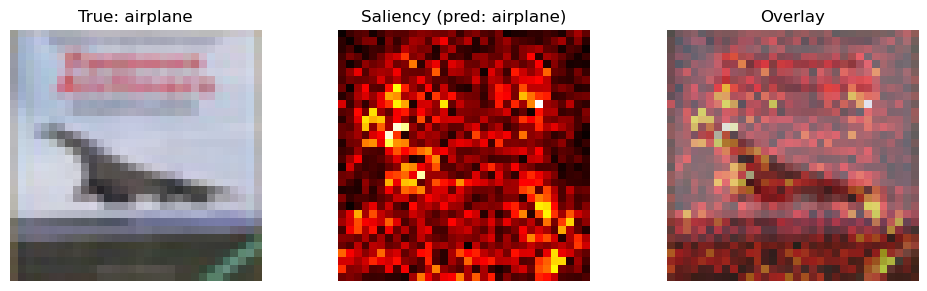

In [7]:
def show_saliency(image, saliency, pred_class, true_label):
    """Display original image, saliency map, and overlay side by side."""
    img_np = unnormalize(image).permute(1, 2, 0).numpy()
    sal_np = saliency.numpy()

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    axes[0].imshow(img_np)
    axes[0].set_title(f"True: {CLASSES[true_label]}")
    axes[0].axis("off")

    axes[1].imshow(sal_np, cmap="hot")
    axes[1].set_title(f"Saliency (pred: {CLASSES[pred_class]})")
    axes[1].axis("off")

    axes[2].imshow(img_np)
    axes[2].imshow(sal_np, cmap="hot", alpha=0.5)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

show_saliency(image, saliency, pred, label)

## 5 -- Multiple Examples

One image isn't enough to draw conclusions. Let's look at saliency maps for several test images to see if the model consistently attends to the object or sometimes relies on background cues.

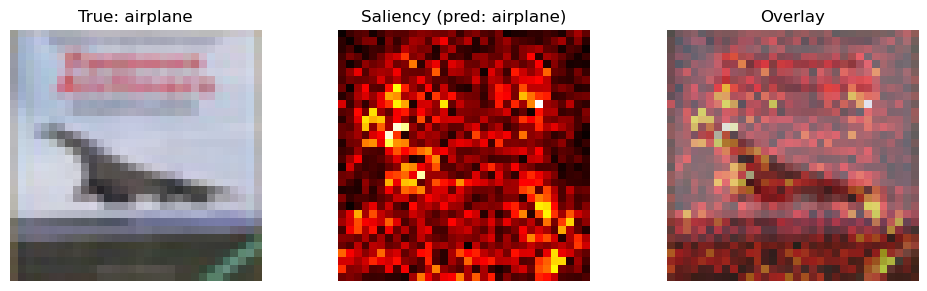

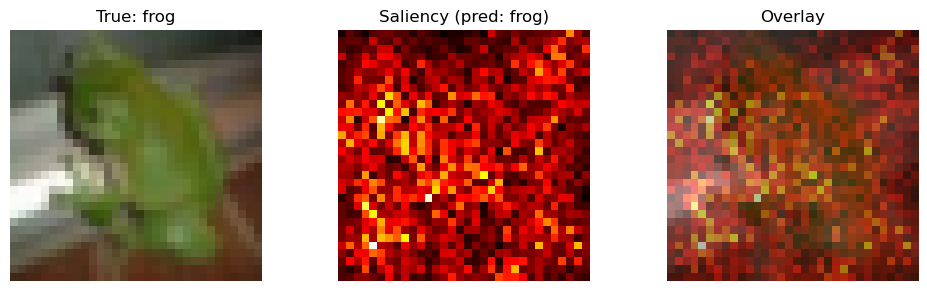

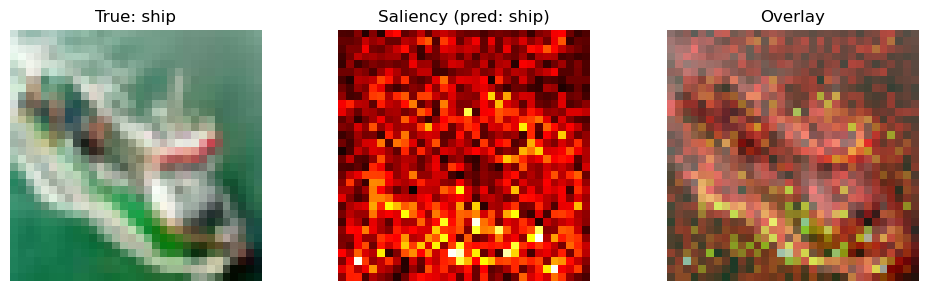

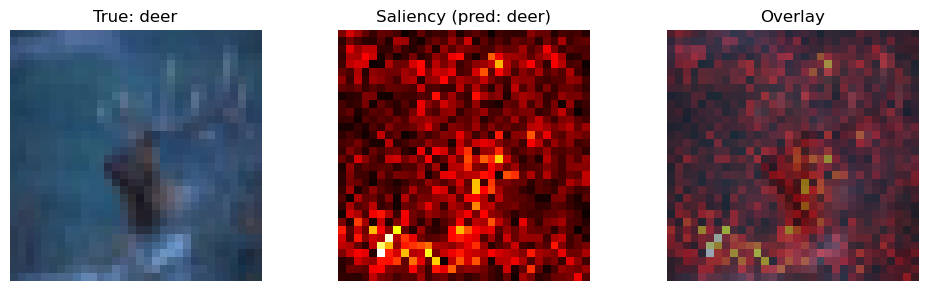

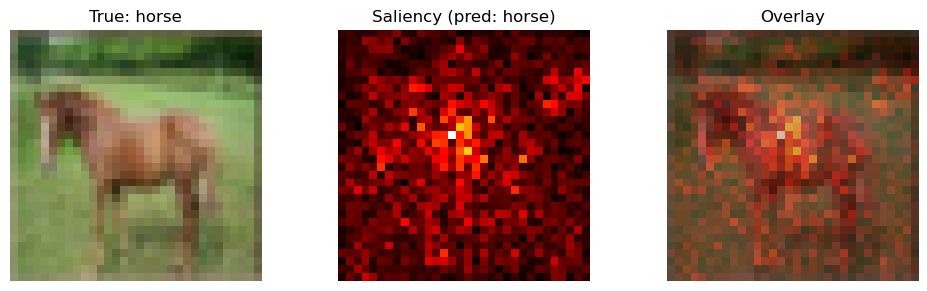

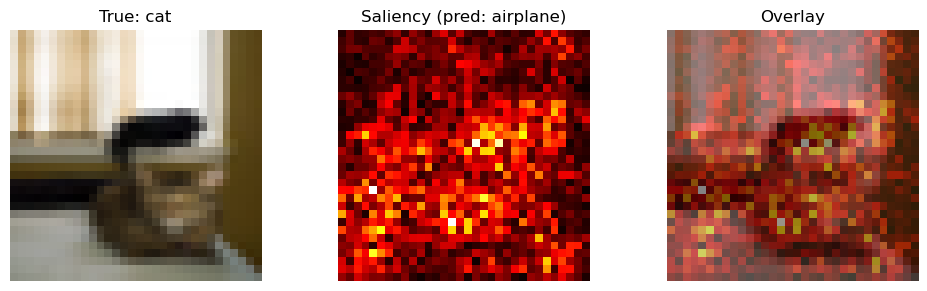

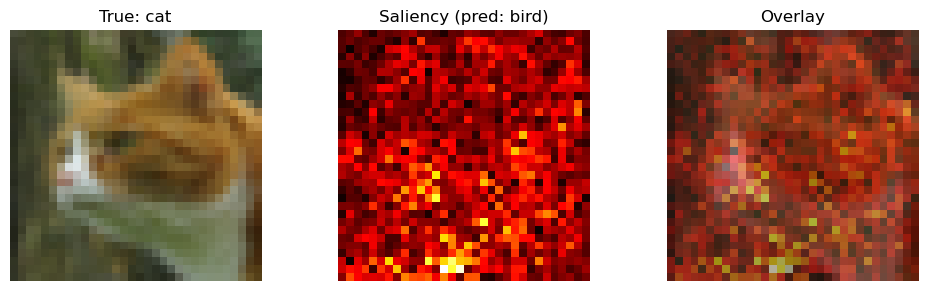

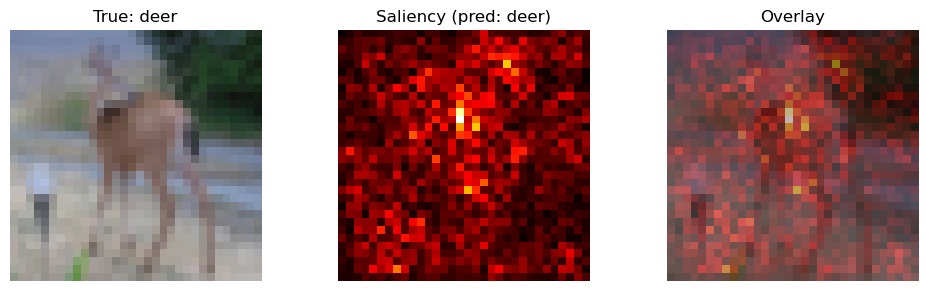

In [8]:
# Pick 8 diverse examples from the test set
indices = [3, 7, 15, 22, 48, 63, 91, 100]

for idx in indices:
    img, lbl = test_ds[idx]
    sal, pred = compute_saliency(model, img, device)
    show_saliency(img, sal, pred, lbl)

## Takeaway

- A saliency map reuses the same backpropagation used for training, but computes gradients with respect to the **input pixels** instead of the **weights**.
- The gradient `dScore/dPixel` tells us how sensitive the model's prediction is to each pixel — high magnitude means the pixel is important for the classification.
- This is the simplest form of interpretability: it requires no architectural changes and works on any differentiable model.
- **Limitations:** vanilla gradient saliency can be noisy and doesn't always highlight clean object boundaries. More advanced methods (SmoothGrad, Grad-CAM, Integrated Gradients) address these issues.
- Connects directly to Zeiler & Fergus (2014), who used a different technique (DeconvNets) to answer the same question: "what is the model looking at?"